# Monocular Depth Estimation Using U-Net and MobileNetV3 on Jetson TX2 NX Devices

This model aims for monocular depth estimation using a U-Net architecture with a MobileNetV3 as the encoder. The model is trained on the DIODE Indoor Dataset.

The model are built using the pytorch and then will be converted to ONNX then to a TensorRT engine for inference on the Jetson TX2 NX device.

The model is trained using the Adam optimizer with a learning rate of 0.0001 (Can be changed). The model is trained using the mean squared error loss function.

For more information on the model, please refer to the following paper: https://arxiv.org/pdf/2004.04572.pdf

An Aditional information can be accessed in the following link: https://github.com/alinstein/Depth_estimation, https://www.kaggle.com/code/muhammadhafil/monocular-depth-estimation and https://www.kaggle.com/code/harits/indoor-depth-estimation-u-net

The dataset used for training can be found in the following link: https://diode-dataset.org/ or https://www.kaggle.com/datasets/soumikrakshit/nyu-depth-v2

# Imports

In [12]:
import numpy as np
import pandas as pd
import time
import datetime
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import kornia
import cv2
from tensorboardX import writer

# Main Library
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.utils as utils
import torchvision.utils as vutils
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, models

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Import Model
from Model import Model

# Import Dataset
from DepthData import DepthDataset, Augmentation, ToTensor

In [2]:
# Check if gpu is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


# Dataset Preparation

In [3]:
train_csv = pd.read_csv('./data/nyu2_train.csv')
train_csv = train_csv.values.tolist()
train_csv = shuffle(train_csv)

# Visualize Depth Map

0 (640, 480) (640, 480)
1 (640, 480) (640, 480)
2 (640, 480) (640, 480)
3 (640, 480) (640, 480)


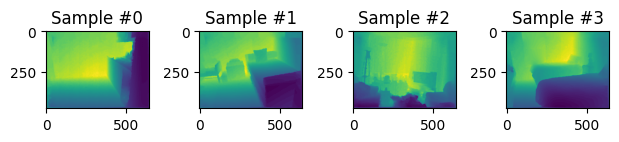

In [4]:
depth_data = DepthDataset(traincsv = train_csv, root_dir = './')
fig = plt.figure()
len(depth_data)

for i in range (len(depth_data)):
    sample = depth_data[i]
    print(i, sample['image'].size, sample['depth'].size)
    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    plt.imshow(sample['depth'])
    if i == 3:
        plt.show()
        break

# Loss Function

We will be using SSIM (Structural Similarity Index), RMSE (Root Mean Squared Error) and MAE (Mean Absolute Error) as our loss functions.

In [ ]:
def ssim(img1, img2, val_range, window_size=11, window=None, size_average=True, full=False):
    ssim = kornia.losses.SSIM(window_size=window_size, max_val=val_range, reduction='none')
    return ssim(img1, img2)

# Normalize

In [5]:
def DepthNorm(depth, maxDepth = 1000.0):
    return maxDepth / depth

class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n = 1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def colorize(value, vmin = 10, vmax = 1000, cmap = 'plasma'):
    value = value.cpu().numpy()[0, :, :]

    vmin = value.min() if vmin is None else vmin
    vmax = value.max() if vmax is None else vmax

    if vmin != vmax:
        value = (value - vmin) / (vmax - vmin)
    else:
        value = value * 0

    cmapper = plt.cm.get_cmap(cmap)
    value = cmapper(value, bytes = True)

    img = value[:, :, :3]

    return img.transpose((2, 0, 1))

# Log

In [7]:
def LogProgress(model, writer, test_loader, epoch):
    model.eval()
    sequential = test_loader
    sample_batched = next(iter(sequential))

    image = torch.autograd.Variable(sample_batched['image'].cuda())
    depth = torch.autograd.Variable(sample_batched['depth'].cuda(non_blocking = True))

    if epoch == 0: writer.add_image('Train.1.Image', vutils.make_grid(image.data, nrow = 6, normalize = True), epoch)
    if epoch == 0: writer.add_image('Train.2.Depth', colorize(vutils.make_grid(depth.data, nrow = 6, normalize = False)), epoch)

    output = DepthNorm(model(image))

    writer.add_image('Train.3.Ours', colorize(vutils.make_grid(output.data, nrow = 6, normalize = False)), epoch)
    writer.add_image('Train.4.Error', colorize(vutils.make_grid(torch.abs(output - depth).data, nrow = 6, normalize = False)), epoch)

    del image
    del depth
    del output

# Model Architecture

This model uses a U-Net architecture with a MobileNetV3 as the encoder. The model will be trained on the NYU Depth V2 dataset.

The model already built on Model.py file.

In [8]:
model = Model().to(device) # Change Model().to(device) to Model.cuda() if you want to use GPU

# If Host has GPU
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model)
else :
    print("Let's use CPU!")
    model = nn.DataParallel(model)

print("Model Loaded")

Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to C:\Users\brian/.cache\torch\hub\checkpoints\mobilenet_v3_small-047dcff4.pth
100.0%


Let's use CPU!
Model Loaded


In [9]:
# Hyperparameters
num_epochs = 50
batch_size = 64
learning_rate = 1e-4

In [10]:
depth_data = DepthDataset(traincsv = train_csv, root_dir = './', transform = transforms.Compose([Augmentation(0.5), ToTensor()]))
train_loader = DataLoader(depth_data, batch_size = batch_size, shuffle = True)

# Loss and Optimizer (RMSE and MAE Loss with Adam Optimizer)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

# Training

In [ ]:
for epoch in range(num_epochs):
    path = './train/' + str(epoch) + '.pth'
    torch.save(model.state_dict(), path)
    batch_time = AverageMeter()
    losses = AverageMeter()
    N = len(train_loader)

    # Switch to train mode
    model.train()

    end = time.time()

    for i, sample_batched in enumerate(train_loader):
        optimizer.zero_grad()

        image = torch.autograd.Variable(sample_batched['image'].cuda())
        depth = torch.autograd.Variable(sample_batched['depth'].cuda(non_blocking = True))

        depth_n = DepthNorm(depth)

        output = model(image)

        l_depth = criterion(output, depth_n)
        l_ssim = torch.clamp((1 - ssim(output, depth_n, val_range = 1000.0 / 10.0)) * 0.5, 0, 1)

        loss = (1.0 * l_ssim.mean()) + (0.1 * l_depth)

        losses.update(loss.data.item(), image.size(0))
        loss.backward()
        optimizer.step()

        # Measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        eta = str(datetime.timedelta(seconds = int(batch_time.val * (N - i))))

        # Log progress
        niter = epoch * len(train_loader) + i
        if i % 5 == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.sum:.3f})\t'
                  'ETA {eta}\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'.format(epoch, i, len(train_loader), batch_time = batch_time, loss = losses, eta = eta))
            
    path = './train/' + str(epoch) + '.pth'
    torch.save(model.state_dict(), path)

    if i % 300 == 0:
        # Log to TensorBoard
        LogProgress(model, writer, train_loader, niter)

    # Log epoch loss
    LogProgress(model, writer, train_loader, niter)
    writer.add_scalar('Train/Loss', losses.avg, epoch)

# Evaluation